In [5]:
print("Load ProtBERT  bfd Model...")
# PROT BERT LOADING :
import torch
import tqdm
from Bio import SeqIO
import time
import numpy as np
import pandas as pd
import os
from transformers import BertModel, BertTokenizer
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case=False )
model = BertModel.from_pretrained("Rostlab/prot_bert_bfd").to(device)

def get_bert_embedding(
    sequence : str,
    len_seq_limit : int
):
    '''
    Function to collect last hidden state embedding vector from pre-trained ProtBERT Model

    INPUTS:
    - sequence (str) : protein sequence (ex : AAABBB) from fasta file
    - len_seq_limit (int) : maximum sequence lenght (i.e nb of letters) for truncation

    OUTPUTS:
    - output_hidden : last hidden state embedding vector for input sequence of length 1024
    '''
    sequence_w_spaces = ' '.join(list(sequence))
    encoded_input = tokenizer(
        sequence_w_spaces,
        truncation=True,
        max_length=len_seq_limit,
        padding='max_length',
        return_tensors='pt').to(device)
    output = model(**encoded_input)
    output_hidden = output['last_hidden_state'][:,0][0].detach().cpu().numpy()
    assert len(output_hidden)==1024
    return output_hidden


DATA_PATH = "../dataset/dataset2.0/" # Path to data
EMBED_PATH =DATA_PATH+'/ProtBert_bfd_embed/'

EMB_LAYER = 33
import tqdm
def extract_embed(data_file):    
    
    input_data  =DATA_PATH+data_file
    output_dir = EMBED_PATH
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data_df = pd.read_csv(input_data)
    num_sequences  =len(data_df)
    ids = []
    embeds = np.zeros((num_sequences, 1024))
    i = 0
    for idnex,row in tqdm.tqdm(data_df.iterrows()):
        ids.append(row['id'])
        embeds[i] = get_bert_embedding(str(row['seq']),len_seq_limit = 1000)
        i += 1
    
    np.save(output_dir+'{}_embeds.npy'.format(data_file.split('.')[0]), embeds)
    np.save(output_dir+'{}_ids.npy'.format(data_file.split('.')[0]), np.array(ids))
    print('Extract T5 embeddings for {}, save in {}'.format(input_data,output_dir))

Load ProtBERT  bfd Model...


Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
for file in os.listdir(DATA_PATH):
    if file.endswith('.csv'):
        print(file)
        extract_embed(file)

test_data1_2023-6-9_15_31.csv


226it [00:25,  8.76it/s]


Extract T5 embeddings for ../dataset/dataset2.0/test_data1_2023-6-9_15_31.csv, save in ../dataset/dataset2.0//ProtBert_bfd_embed/
test_data2_2023-6-9_15_31.csv


274it [00:31,  8.78it/s]


Extract T5 embeddings for ../dataset/dataset2.0/test_data2_2023-6-9_15_31.csv, save in ../dataset/dataset2.0//ProtBert_bfd_embed/
positive_train_422.csv


422it [00:48,  8.69it/s]


Extract T5 embeddings for ../dataset/dataset2.0/positive_train_422.csv, save in ../dataset/dataset2.0//ProtBert_bfd_embed/
negative_train_3307.csv


3307it [06:19,  8.72it/s]

Extract T5 embeddings for ../dataset/dataset2.0/negative_train_3307.csv, save in ../dataset/dataset2.0//ProtBert_bfd_embed/


In [7]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
def load_T5_embed(csv_file):
    Embed_PATH = EMBED_PATH+csv_file.split('.')[0]+'_embeds.npy'
    data_df =  pd.read_csv(DATA_PATH+csv_file)
    ys = data_df['label']
    Xs = np.load(Embed_PATH)
    print('load{} T5 embedding from {}'.format(csv_file,Embed_PATH))
    print(len(ys))
    print(Xs.shape)
    return Xs,ys
Xs = []
ys = []
for file in os.listdir(DATA_PATH):
    if file.endswith('.csv'):
        if file.endswith('llpsdb_d.csv'):continue
        x,y = load_T5_embed(file)
        Xs.append(x)
        ys.append(y)
Xs = np.vstack((*Xs,))
ys = [y for sub in ys for y in sub]
print(len(ys))
print(Xs.shape)
num_pca_components = 100
pca = PCA(num_pca_components)
Xs_pca = pca.fit_transform(Xs)

loadtest_data1_2023-6-9_15_31.csv T5 embedding from ../dataset/dataset2.0//ProtBert_bfd_embed/test_data1_2023-6-9_15_31_embeds.npy
226
(226, 1024)
loadtest_data2_2023-6-9_15_31.csv T5 embedding from ../dataset/dataset2.0//ProtBert_bfd_embed/test_data2_2023-6-9_15_31_embeds.npy
274
(274, 1024)
loadpositive_train_422.csv T5 embedding from ../dataset/dataset2.0//ProtBert_bfd_embed/positive_train_422_embeds.npy
422
(422, 1024)
loadnegative_train_3307.csv T5 embedding from ../dataset/dataset2.0//ProtBert_bfd_embed/negative_train_3307_embeds.npy
3307
(3307, 1024)
4229
(4229, 1024)


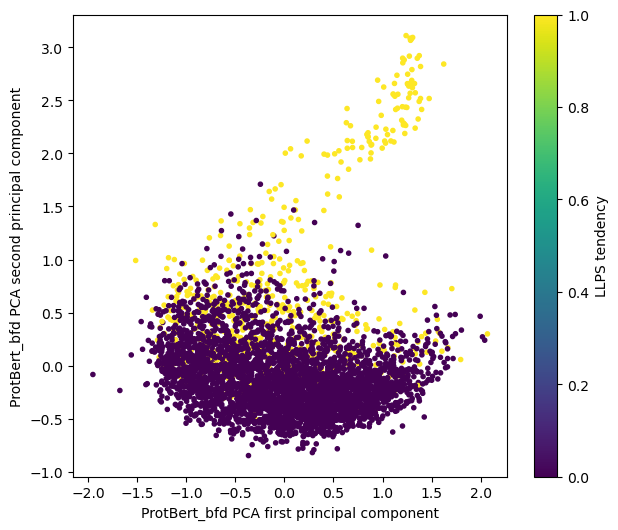

In [8]:
import matplotlib.pyplot as plt
fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_pca[:,0], Xs_pca[:,1], c=ys, marker='.')
ax.set_xlabel('ProtBert_bfd PCA first principal component')
ax.set_ylabel('ProtBert_bfd PCA second principal component')
plt.colorbar(sc, label='LLPS tendency')